In [1]:
from __future__ import absolute_import, division, print_function

import pandas as pd
import numpy as np
import sklearn as sk
import os
import tensorflow as tf
from sklearn.feature_extraction import DictVectorizer
from sklearn.externals import joblib
from sklearn.model_selection import ParameterGrid
import seaborn as sns

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

In [2]:
# %load_ext autoreload
# %autoreload 2

In [3]:
data_path = "../cs238_sepsis_rl/data/"

final_df_train = pd.read_csv(data_path + 'train_state_action_reward_df.csv')
final_df_test = pd.read_csv(data_path+ 'test_state_action_reward_df.csv')

In [4]:
patient_4 = final_df_train[final_df_train['subject_id'] == 4]

In [5]:
patient_4.columns

Index(['subject_id', 'hadm_id', 'icustay_id', 'interval_start_time',
       'interval_end_time', 'ALBUMIN', 'ANION GAP', 'BANDS', 'BICARBONATE',
       'BILIRUBIN', 'BUN', 'CHLORIDE', 'CREATININE', 'DiasBP', 'Glucose',
       'GLUCOSE', 'HeartRate', 'HEMATOCRIT', 'HEMOGLOBIN', 'INR', 'LACTATE',
       'MeanBP', 'PaCO2', 'PLATELET', 'POTASSIUM', 'PT', 'PTT', 'RespRate',
       'SODIUM', 'SpO2', 'SysBP', 'TempC', 'WBC', 'age', 'is_male',
       'race_white', 'race_black', 'race_hispanic', 'race_other', 'height',
       'weight', 'vent', 'sofa', 'lods', 'sirs', 'qsofa', 'qsofa_sysbp_score',
       'qsofa_gcs_score', 'qsofa_resprate_score', 'elixhauser_hospital',
       'blood_culture_positive', 'discrete_action', 'hospital_expire_flag',
       'reward', 'row_id', 'row_id_next'],
      dtype='object')

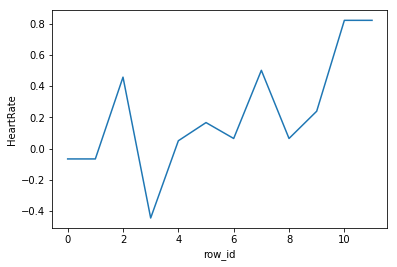

In [6]:
# look at one patient
sns.lineplot(x="row_id", y="HeartRate",
             data=patient_4)

In [7]:
# look at action counts
final_df_train.groupby("discrete_action").count()['subject_id']

discrete_action
0     38195
5     26880
6       655
7       493
8       482
9       298
10    26885
11      470
12      459
13      484
14      518
15    26549
16      492
17      572
18      659
19      710
20    22947
21     1419
22     1530
23     1448
24     1437
Name: subject_id, dtype: int64

In [8]:
final_df_train.groupby("hospital_expire_flag").count()

,subject_id,hadm_id,icustay_id,interval_start_time,interval_end_time,ALBUMIN,ANION GAP,BANDS,BICARBONATE,BILIRUBIN,...,qsofa,qsofa_sysbp_score,qsofa_gcs_score,qsofa_resprate_score,elixhauser_hospital,blood_culture_positive,discrete_action,reward,row_id,row_id_next
hospital_expire_flag,,,,,,,,,,,,,,,,,,,,,
0,131773,131773,131773,131773,131773,131773,131773,131773,131773,131773,...,131773,131773,131773,131773,131773,131773,131773,131773,131773,131773
1,21809,21809,21809,21809,21809,21809,21809,21809,21809,21809,...,21809,21809,21809,21809,21809,21809,21809,21809,21809,21809


In [9]:
# create data for RNN
final_df_train.head()

,subject_id,hadm_id,icustay_id,interval_start_time,interval_end_time,ALBUMIN,ANION GAP,BANDS,BICARBONATE,BILIRUBIN,...,qsofa_sysbp_score,qsofa_gcs_score,qsofa_resprate_score,elixhauser_hospital,blood_culture_positive,discrete_action,hospital_expire_flag,reward,row_id,row_id_next
0,4,185777,294638,2191-03-15T12:00:00Z,2191-03-15T16:00:00Z,-0.058925,0.767654,-0.297663,0.040999,0.048183,...,0.540022,-0.57893,0.390655,1.007645,1.461582,0,0,0,0.0,1.0
1,4,185777,294638,2191-03-15T20:00:00Z,2191-03-16T00:00:00Z,-0.058925,0.767654,-0.297663,0.040999,0.048183,...,0.540022,-0.57893,0.390655,1.007645,1.461582,0,0,0,1.0,2.0
2,4,185777,294638,2191-03-16T00:00:00Z,2191-03-16T04:00:00Z,-0.058925,0.767654,-0.297663,0.040999,0.048183,...,0.540022,-0.57893,0.390655,1.007645,1.461582,10,0,0,2.0,3.0
3,4,185777,294638,2191-03-16T04:00:00Z,2191-03-16T08:00:00Z,-0.487176,0.271412,-0.297663,-0.600421,-0.020244,...,0.540022,-0.57893,0.390655,1.007645,1.461582,20,0,0,3.0,4.0
4,4,185777,294638,2191-03-16T08:00:00Z,2191-03-16T12:00:00Z,-0.487176,0.271412,-0.297663,-0.600421,-0.020244,...,0.540022,-0.57893,0.390655,1.007645,1.461582,5,0,0,4.0,5.0


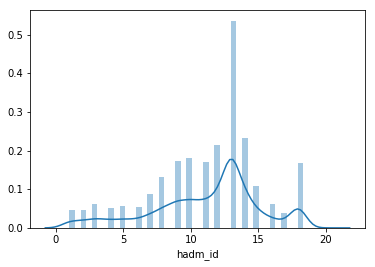

In [10]:
# episode length distribution
sns.distplot(final_df_train.groupby("subject_id").count()["hadm_id"])

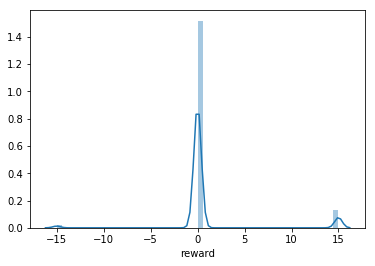

In [11]:
# reward distribution
sns.distplot(final_df_train["reward"])

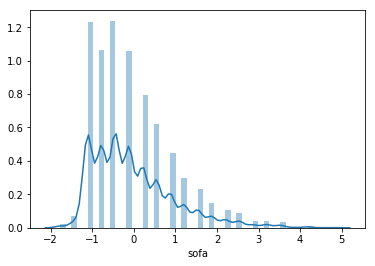

In [15]:
# sofa distribution
sns.distplot(final_df_test["sofa"])

(array([9507.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0., 6763.,    0.,  164.,    0.,  120.,    0.,  107.,    0.,
          87.,    0., 6957.,    0.,  125.,    0.,    0.,  113.,    0.,
         107.,    0.,  125.,    0., 6926.,    0.,  134.,    0.,  141.,
           0.,  150.,    0.,  199.,    0., 6047.,    0.,  339.,    0.,
         367.,    0.,  355.,    0.,  399.]),
 array([ 0.  ,  0.48,  0.96,  1.44,  1.92,  2.4 ,  2.88,  3.36,  3.84,
         4.32,  4.8 ,  5.28,  5.76,  6.24,  6.72,  7.2 ,  7.68,  8.16,
         8.64,  9.12,  9.6 , 10.08, 10.56, 11.04, 11.52, 12.  , 12.48,
        12.96, 13.44, 13.92, 14.4 , 14.88, 15.36, 15.84, 16.32, 16.8 ,
        17.28, 17.76, 18.24, 18.72, 19.2 , 19.68, 20.16, 20.64, 21.12,
        21.6 , 22.08, 22.56, 23.04, 23.52, 24.  ]),
 <a list of 50 Patch objects>)

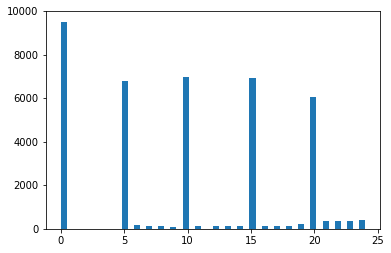

In [16]:
# sofa distribution
import matplotlib.pyplot as plt
plt.hist(final_df_test["discrete_action"], bins=50)